# Installs

In [ ]:
!pip install fastai

# Imports

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from skimage import exposure
from fastai.vision.all import *
from google.colab import drive
from google.colab import files 
from pathlib import Path
import os
from fastai.callback.tracker import EarlyStoppingCallback
import PIL

# Setup

In [3]:
drive.mount('/content/gdrive')
DATA = Path('/content/gdrive/MyDrive/DAT255/x-ray')
DATA.mkdir(exist_ok=True, parents=True)

Mounted at /content/gdrive


In [4]:
if not os.path.exists(DATA/'sample'):
    files.upload()
    !ls -lha kaggle.json
    !pip install -q kaggle --upgrade
    # The Kaggle API client expects this file to be in ~/.kaggle,
    # so move it there.
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/

    # This permissions change avoids a warning on Kaggle tool startup.
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d nih-chest-xrays/sample

    !unzip -q sample.zip -d '/content/gdrive/MyDrive/DAT255/x-ray'

# Check the CSV

In [5]:
data = pd.read_csv(DATA/'sample/sample_labels.csv')

In [6]:

data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneumothorax,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [7]:
image_path = DATA/'sample/images/00000013_005.png'

In [8]:
image = Image.open(image_path)

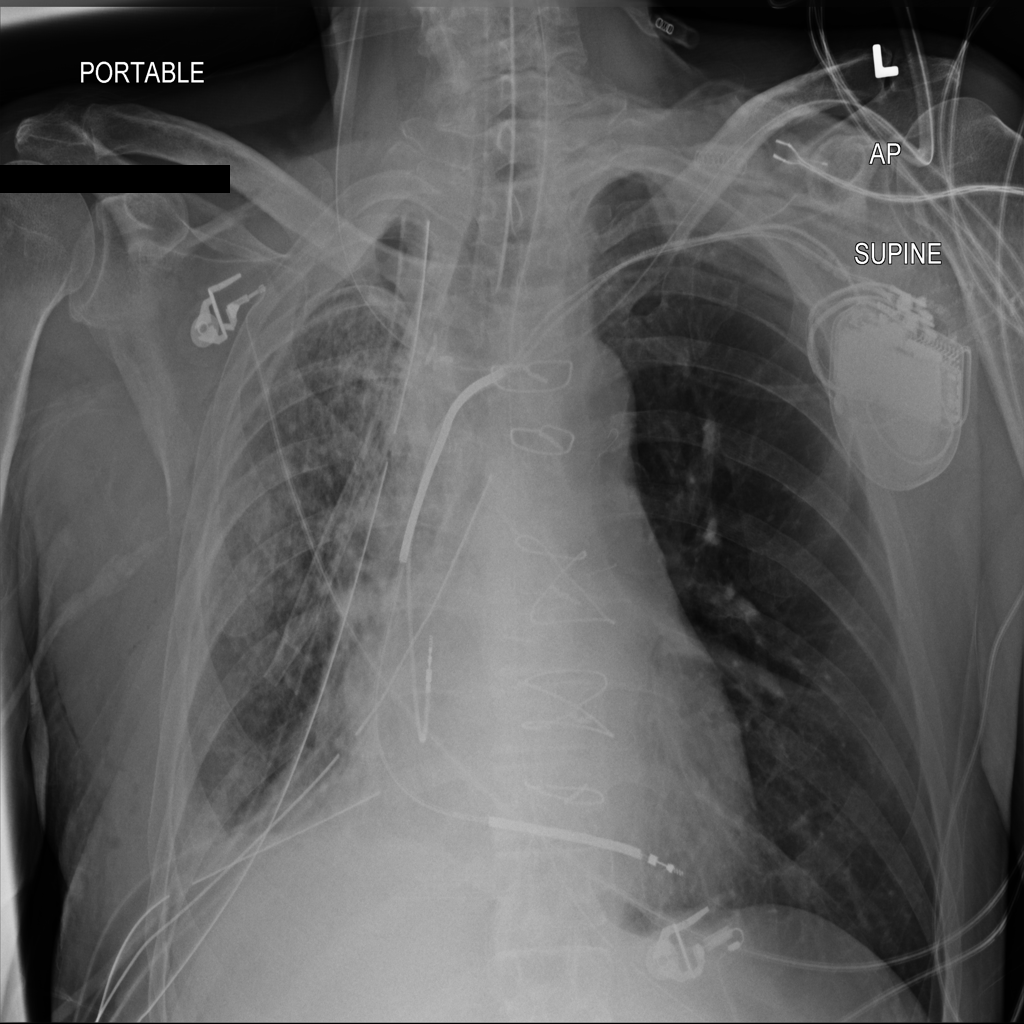

In [9]:
image.show()

# Make an Enhancer

In [33]:
from PIL import ImageOps

In [72]:
def enhance_image(img: PIL.Image.Image):
    # Convert to grayscale
    img = img.convert('L')
    
    # Apply histogram equalization to improve contrast
    enhanced_img = ImageOps.equalize(img)

    return enhanced_img

In [24]:
class EnhanceImage(Transform):
    def __init__(self):
        pass

    def encodes(self, x: PIL.Image.Image):
        return enhance_image(x)

    def decodes(self, x: PIL.Image.Image):
        return x

# Create a Datablock

In [73]:
dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('Image Index', pref=DATA/'sample/images/'),
    get_y=ColReader('Finding Labels', label_delim='|'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=[Resize(460), EnhanceImage()],
    batch_tfms=[*aug_transforms(do_flip=False), Normalize.from_stats(*imagenet_stats)]
).dataloaders(data, bs=64)

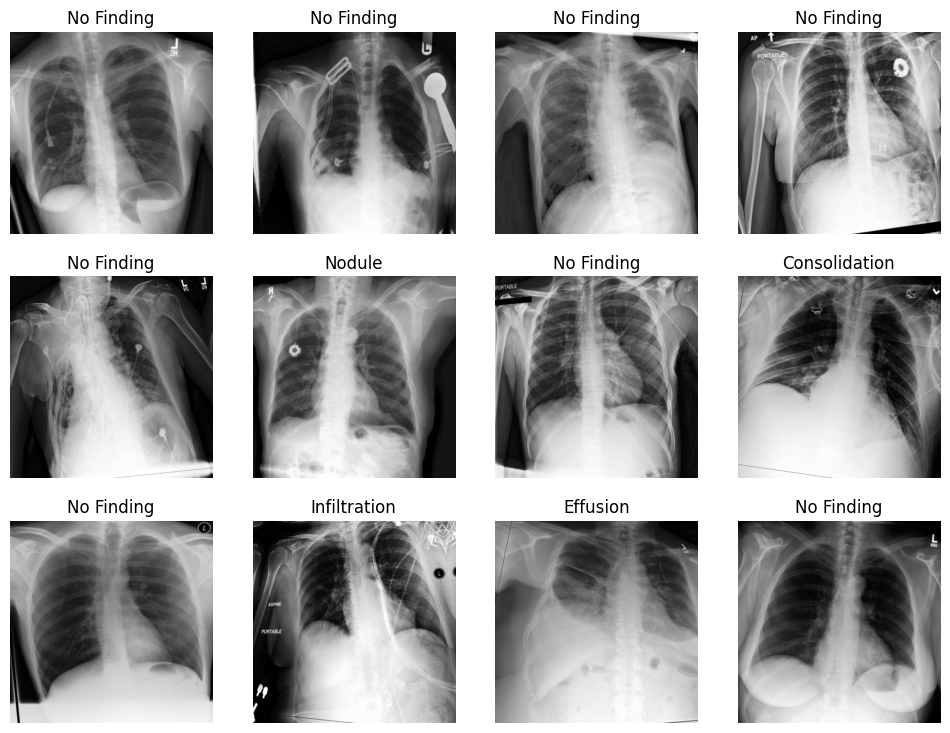

In [74]:
dls.show_batch(max_n=12)

# Train a Learner

In [68]:
loss_func = nn.BCEWithLogitsLoss()

In [69]:
cbs = [EarlyStoppingCallback(patience=3)]

In [75]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2), loss_func=loss_func, pretrained=True, cbs=cbs).to_fp16()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


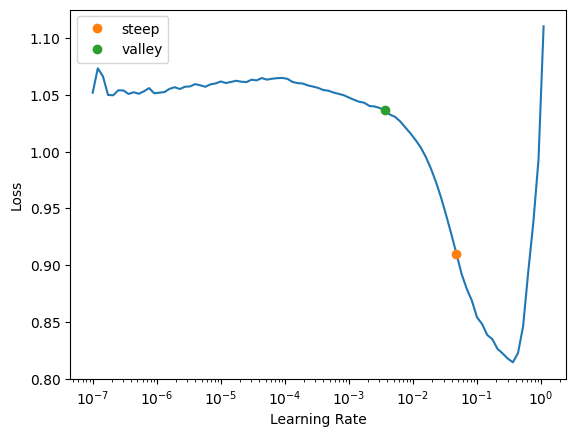

In [76]:
lr = learn.lr_find(suggest_funcs=(steep, valley))

In [77]:
base_lr = (lr.steep + lr.valley)/2
base_lr

0.02574689546599984

In [78]:
learn.fine_tune(15, base_lr)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.432324,0.273357,0.846685,07:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224803,0.224870,0.881832,03:12
1,0.214463,0.283055,0.912162,03:11
2,0.209886,0.230936,0.883437,03:12
3,0.213435,0.204152,0.900565,03:11
4,0.207239,0.212744,0.882367,03:12
5,0.202230,0.327765,0.913411,03:12
6,0.200496,0.263439,0.911865,03:13


No improvement since epoch 3: early stopping


# Export learner

In [79]:
learn.export(DATA/'model_resnet50_v2.pkl')